In [2]:
import os
from pathlib import Path
from omegaconf import OmegaConf
from copy import deepcopy
from typing import List, Union, Dict, Any

from sklearn.metrics import f1_score, accuracy_score, classification_report

os.chdir("../src")  # Change to project root directory

from config import DatasetConfig, ConceptDatasetConfig
from models.architectures import CBMSequentialEfficientNetFCN
from config import CBMTrainerConfig
from models.trainer.cbm_trainer import CBMTrainer
from models.architectures import EfficientNetv2
from models.trainer.standard_trainer import StandardTrainer
from config.training_config import TrainingConfig
from config.training_config import ConceptTrainingConfig

2025-10-22 11:25:16.855088: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-22 11:25:16.870795: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761125116.887767   63081 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761125116.892897   63081 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-22 11:25:16.910611: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Functions

In [3]:

def load_config(config_path, configClass = CBMTrainerConfig, overrides: Union[List[str], Dict[str, Any], None] = None):
    """
    Load the configuration from a YAML file.
    """
    # Load YAML
    cfg_yaml = OmegaConf.load(config_path)
    cfg_structured = OmegaConf.structured(configClass)
    cfg = OmegaConf.merge(cfg_structured, cfg_yaml)
    cfg = OmegaConf.to_object(cfg)

    if overrides is not None:
        overrides_cfg = None
        if isinstance(overrides, list):
            # Create a DictConfig from a dot-list (e.g., ["model.hidden_size=512", "lr=0.001"])
            overrides_cfg = OmegaConf.from_dotlist(overrides)
        elif isinstance(overrides, dict):
            # Create a DictConfig from a standard dictionary
            overrides_cfg = OmegaConf.create(overrides)
        
        if overrides_cfg is not None:
            cfg = OmegaConf.merge(cfg, overrides_cfg)
            cfg = OmegaConf.to_object(cfg)

    cfg.resolve()
    return cfg

In [4]:
import numpy as np
import torch
import tqdm
from sklearn.metrics import classification_report
import logging

def compute_accuracy(outputs, targets):
    """
    Compute the accuracy of the model's predictions.

    Parameters:
        outputs (torch.Tensor): Model outputs.
        labels (torch.Tensor): Ground truth labels.

    Returns:
        float: Accuracy of the predictions.
    """
    _, predicted = outputs.max(1)
    correct = predicted.eq(targets).sum().item()
    total = targets.size(0)
    return correct, total

@torch.no_grad()
def test_label_gt(model, dataloader, device):
    """
    Evaluate the model on the provided dataloader.

    Parameters:
        dataloader (DataLoader): DataLoader for the dataset to evaluate.
        mode (str): 'val' for validation or 'test' for final evaluation.

    Returns:
        tuple: Average loss and accuracy for the dataset.
    """
    model.eval()
    STEPS = len(dataloader)

    y_true = []
    y_pred = []

    running_loss = 0.0
    running_correct = 0
    running_total = 0

    with tqdm.trange(STEPS, desc=f"GT Evaluation") as progress:
        for batch_idx, (idx, inputs, (concepts, labels)) in enumerate(dataloader):
            inputs, concepts, labels = inputs.to(device), concepts.to(device), labels.to(device)

            pred_labels = model(concepts)

            # Measuring Accuracy
            correct, total = compute_accuracy(pred_labels, labels)
            running_correct += correct
            running_total += total

            y_true.extend(labels.cpu().numpy())
            _, pred_labels = torch.max(pred_labels, 1)
            y_pred.extend(pred_labels.cpu().numpy())

            progress.update(1)

    accuracy = running_correct / running_total

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)


    report = f"Labels: \n {classification_report(y_true, y_pred)}"
    print(report)
    return None, accuracy

# Loading configs

In [5]:
from config.standard_trainer_config import StandardTrainerConfig


std_overrides = [
        "device_no=1",
        "dataset.name=gtsrb",
        "dataset.n_labels=43",
        "dataset.data_path=../../data/raw/GTSRB/converted",
        ]

concept_overrides = [
        *std_overrides,
        "device_no=1",
        "dataset.n_concepts=43",
        "dataset.concepts_file=../../data/raw/GTSRB/concepts/concepts_per_class.csv"
        ]


std_config = load_config(
    Path("/vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/configs/RQ1_GTSRB_CNN_config_standard.yaml"),
    configClass=StandardTrainerConfig,
    overrides=std_overrides
    )

fuzzy_config = load_config(
    Path("/vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/configs/RQ1_GTSRB_CBM_config_fuzzy_testing.yaml"),
    overrides=concept_overrides
    )

baseline_config = load_config(
    Path("/vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/configs/RQ1_GTSRB_CBM_config_baseline.yaml"),
    overrides=concept_overrides
    )

Directory 'experiments/20251022_112512_s42' created successfully.
Directory 'experiments_testing/20251022_112512_s42' created successfully.
Directory 'experiments/20251022_112512_s42' created successfully.


# Load Dataset

In [6]:
# Regular dataset
(train_loader,
 val_loader,
 test_loader) = (std_config.dataset
                    .factory(
                        seed=std_config.seed, 
                        config=std_config.dataset
                    )
                    .get_dataloaders()
                )

train_transform: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
test_transform: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [7]:
# Concept dataset
(concept_train_loader,
 concept_val_loader,
 concept_test_loader) = (baseline_config.dataset
                            .factory(
                                seed=baseline_config.seed, 
                                config=baseline_config.dataset
                            )
                            .get_dataloaders()
                        )

train_transform: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
test_transform: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


# Load trained Models

In [8]:
def load_cbm_model(config, directory):
    config.concept_predictor.pretrained_weights = directory
    trainer = CBMTrainer(
        config=config,
        model=CBMSequentialEfficientNetFCN(config),
        train_loader=concept_train_loader,
        val_loader=concept_val_loader,
        test_loader=concept_test_loader,
    )
    return trainer

def load_standard_model(config, directory):
    config.training.pretrained_weights = directory
    trainer = StandardTrainer(
        config=config.training,
        model=EfficientNetv2(config.dataset.n_labels).to(config.device),
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        device=std_config.device,
    )
    return trainer

In [9]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score
import pandas as pd


def get_f1_scores(y_true, y_pred):
    return {
        "micro": f1_score(y_true, y_pred, average='micro'),
        "macro": f1_score(y_true, y_pred, average='macro'),
        "weighted": f1_score(y_true, y_pred, average='weighted'),
    }

def get_precision(y_true, y_pred):
    return {
        "micro": precision_score(y_true, y_pred, average='micro'),
        "macro": precision_score(y_true, y_pred, average='macro'),
        "weighted": precision_score(y_true, y_pred, average='weighted'),
    }

def get_recall(y_true, y_pred):
    return {
        "micro": recall_score(y_true, y_pred, average='micro'),
        "macro": recall_score(y_true, y_pred, average='macro'),
        "weighted": recall_score(y_true, y_pred, average='weighted'),
    }

def get_accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

def compute_accuracy_per_prediction(y_true, y_pred):
    correct = np.sum(np.all(y_pred.astype(float) == y_true.astype(float), axis=1))
    total = len(y_true)

    return correct/total

def compute_metrics(y_true, y_pred, concepts=False):
    results = {
        "accuracy": get_accuracy(y_true, y_pred),
        "f1": get_f1_scores(y_true, y_pred),
        "precision": get_precision(y_true, y_pred),
        "recall": get_recall(y_true, y_pred),
    }

    if concepts:
        results["concepts_accuracy_per_prediction"] = compute_accuracy_per_prediction(y_true, y_pred)

    return results




def evaluate_model_results(model, dataloader, seed):
    y_true, y_pred = model.test(mode="eval", dataloader=dataloader)
    metrics = compute_metrics(y_true, y_pred)
    df = pd.DataFrame(metrics).stack().rename(seed).to_frame().T
    return df

In [10]:
rq1_results_path = Path("/vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1")

In [11]:
def get_model_results(models_path, model_config, dataloader):
    model_names = os.listdir(models_path)
    concepts_df = pd.DataFrame()
    labels_df = pd.DataFrame()

    i = 0

    for model_name in model_names:
        print(f"iteration {i}")
        print(f"Evaluating Baseline CBM model: {model_name}")
        model_directory = models_path / model_name
        trainer = load_cbm_model(model_config, model_directory)
        concept_results = evaluate_model_results(trainer.concept_predictor_trainer, dataloader, seed=model_name.split("_")[2])
        label_results = evaluate_model_results(trainer.label_predictor_trainer, dataloader, seed=model_name.split("_")[2])

        concepts_df = pd.concat([concepts_df, concept_results])
        labels_df = pd.concat([labels_df, label_results])

        i += 1
        # if i > 1:
        #     break
    return concepts_df, labels_df

In [18]:
baseline_models_path = rq1_results_path / "models" / "baseline_cbm"
baseline_concepts, baseline_labels = get_model_results(baseline_models_path, baseline_config, concept_test_loader)

iteration 0
Evaluating Baseline CBM model: 20251016_224526_s89_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/baseline_cbm/20251016_224526_s89_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.64it/s]


iteration 1
Evaluating Baseline CBM model: 20251016_224526_s263_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/baseline_cbm/20251016_224526_s263_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.85it/s]


iteration 2
Evaluating Baseline CBM model: 20251016_224526_s469_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/baseline_cbm/20251016_224526_s469_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.57it/s]


iteration 3
Evaluating Baseline CBM model: 20251016_224526_s613_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/baseline_cbm/20251016_224526_s613_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.78it/s]


iteration 4
Evaluating Baseline CBM model: 20251016_224526_s687_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/baseline_cbm/20251016_224526_s687_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.51it/s]


iteration 5
Evaluating Baseline CBM model: 20251016_224526_s712_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/baseline_cbm/20251016_224526_s712_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.62it/s]


iteration 6
Evaluating Baseline CBM model: 20251016_224526_s852_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/baseline_cbm/20251016_224526_s852_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.56it/s]


iteration 7
Evaluating Baseline CBM model: 20251016_224526_s884_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/baseline_cbm/20251016_224526_s884_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.67it/s]


iteration 8
Evaluating Baseline CBM model: 20251016_224526_s940_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/baseline_cbm/20251016_224526_s940_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.76it/s]


iteration 9
Evaluating Baseline CBM model: 20251016_224526_s941_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/baseline_cbm/20251016_224526_s941_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.81it/s]


iteration 10
Evaluating Baseline CBM model: 20251016_224601_s20_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/baseline_cbm/20251016_224601_s20_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.74it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.55it/s]


iteration 11
Evaluating Baseline CBM model: 20251016_224601_s149_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/baseline_cbm/20251016_224601_s149_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.76it/s]


iteration 12
Evaluating Baseline CBM model: 20251016_224601_s225_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/baseline_cbm/20251016_224601_s225_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.67it/s]


iteration 13
Evaluating Baseline CBM model: 20251016_224601_s380_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/baseline_cbm/20251016_224601_s380_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.73it/s]


iteration 14
Evaluating Baseline CBM model: 20251016_224601_s443_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/baseline_cbm/20251016_224601_s443_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.57it/s]


iteration 15
Evaluating Baseline CBM model: 20251016_224601_s519_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/baseline_cbm/20251016_224601_s519_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.62it/s]


iteration 16
Evaluating Baseline CBM model: 20251016_224601_s595_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/baseline_cbm/20251016_224601_s595_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.47it/s]


iteration 17
Evaluating Baseline CBM model: 20251016_224601_s834_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/baseline_cbm/20251016_224601_s834_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.68it/s]


iteration 18
Evaluating Baseline CBM model: 20251016_224601_s907_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/baseline_cbm/20251016_224601_s907_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.65it/s]


iteration 19
Evaluating Baseline CBM model: 20251016_224601_s938_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/baseline_cbm/20251016_224601_s938_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.55it/s]


iteration 20
Evaluating Baseline CBM model: 20251016_224653_s41_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/baseline_cbm/20251016_224653_s41_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.65it/s]


iteration 21
Evaluating Baseline CBM model: 20251016_224653_s64_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/baseline_cbm/20251016_224653_s64_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.78it/s]


iteration 22
Evaluating Baseline CBM model: 20251016_224653_s110_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/baseline_cbm/20251016_224653_s110_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.69it/s]


iteration 23
Evaluating Baseline CBM model: 20251016_224653_s126_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/baseline_cbm/20251016_224653_s126_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.71it/s]


iteration 24
Evaluating Baseline CBM model: 20251016_224653_s155_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/baseline_cbm/20251016_224653_s155_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.63it/s]


iteration 25
Evaluating Baseline CBM model: 20251016_224653_s229_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/baseline_cbm/20251016_224653_s229_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.69it/s]


iteration 26
Evaluating Baseline CBM model: 20251016_224653_s269_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/baseline_cbm/20251016_224653_s269_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.63it/s]


iteration 27
Evaluating Baseline CBM model: 20251016_224653_s489_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/baseline_cbm/20251016_224653_s489_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.70it/s]


iteration 28
Evaluating Baseline CBM model: 20251016_224653_s589_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/baseline_cbm/20251016_224653_s589_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.44it/s]


iteration 29
Evaluating Baseline CBM model: 20251016_224653_s714_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/baseline_cbm/20251016_224653_s714_baseline_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.65it/s]


In [19]:
fuzzy_models_path = rq1_results_path / "models" / "fuzzy_cbm" / "testing"
fuzzy_concepts, fuzzy_labels = get_model_results(fuzzy_models_path, fuzzy_config, concept_test_loader)

iteration 0
Evaluating Baseline CBM model: 20251020_223819_s155_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/testing/20251020_223819_s155_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.65it/s]


iteration 1
Evaluating Baseline CBM model: 20251020_223810_s380_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/testing/20251020_223810_s380_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.56it/s]


iteration 2
Evaluating Baseline CBM model: 20251020_223800_s884_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/testing/20251020_223800_s884_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:19<00:00, 10.41it/s]


iteration 3
Evaluating Baseline CBM model: 20251020_223810_s907_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/testing/20251020_223810_s907_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.58it/s]


iteration 4
Evaluating Baseline CBM model: 20251020_223819_s589_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/testing/20251020_223819_s589_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.54it/s]


iteration 5
Evaluating Baseline CBM model: 20251020_223800_s613_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/testing/20251020_223800_s613_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.54it/s]


iteration 6
Evaluating Baseline CBM model: 20251020_223810_s149_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/testing/20251020_223810_s149_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.44it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.45it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-de

iteration 7
Evaluating Baseline CBM model: 20251020_223800_s469_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/testing/20251020_223800_s469_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.49it/s]


iteration 8
Evaluating Baseline CBM model: 20251020_223819_s229_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/testing/20251020_223819_s229_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.51it/s]


iteration 9
Evaluating Baseline CBM model: 20251020_223810_s20_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/testing/20251020_223810_s20_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.75it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.46it/s]


iteration 10
Evaluating Baseline CBM model: 20251020_223819_s126_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/testing/20251020_223819_s126_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.56it/s]


iteration 11
Evaluating Baseline CBM model: 20251020_223810_s938_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/testing/20251020_223810_s938_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.62it/s]


iteration 12
Evaluating Baseline CBM model: 20251020_223800_s852_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/testing/20251020_223800_s852_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.83it/s]


iteration 13
Evaluating Baseline CBM model: 20251020_223810_s595_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/testing/20251020_223810_s595_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.60it/s]


iteration 14
Evaluating Baseline CBM model: 20251020_223819_s41_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/testing/20251020_223819_s41_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.71it/s]


iteration 15
Evaluating Baseline CBM model: 20251020_223800_s940_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/testing/20251020_223800_s940_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.46it/s]


iteration 16
Evaluating Baseline CBM model: 20251020_223819_s64_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/testing/20251020_223819_s64_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.74it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.46it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-de

iteration 17
Evaluating Baseline CBM model: 20251020_223810_s834_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/testing/20251020_223810_s834_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.76it/s]


iteration 18
Evaluating Baseline CBM model: 20251020_223800_s89_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/testing/20251020_223800_s89_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.52it/s]


iteration 19
Evaluating Baseline CBM model: 20251020_223819_s489_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/testing/20251020_223819_s489_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.68it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.52it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-de

iteration 20
Evaluating Baseline CBM model: 20251020_223800_s941_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/testing/20251020_223800_s941_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.63it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.58it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-de

iteration 21
Evaluating Baseline CBM model: 20251020_223810_s519_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/testing/20251020_223810_s519_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.57it/s]


iteration 22
Evaluating Baseline CBM model: 20251020_223819_s714_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/testing/20251020_223819_s714_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.51it/s]


iteration 23
Evaluating Baseline CBM model: 20251020_223800_s687_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/testing/20251020_223800_s687_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.66it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.52it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-de

iteration 24
Evaluating Baseline CBM model: 20251020_223810_s225_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/testing/20251020_223810_s225_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.52it/s]


iteration 25
Evaluating Baseline CBM model: 20251020_223800_s712_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/testing/20251020_223800_s712_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.66it/s]


iteration 26
Evaluating Baseline CBM model: 20251020_223819_s269_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/testing/20251020_223819_s269_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.72it/s]


iteration 27
Evaluating Baseline CBM model: 20251020_223800_s263_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/testing/20251020_223800_s263_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.68it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.66it/s]


iteration 28
Evaluating Baseline CBM model: 20251020_223810_s443_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/testing/20251020_223810_s443_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.43it/s]


iteration 29
Evaluating Baseline CBM model: 20251020_223819_s110_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/testing/20251020_223819_s110_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.68it/s]


In [20]:
fuzzy_models_path_loading = rq1_results_path / "models" / "fuzzy_cbm" / "loading"
fuzzy_concepts_loading, fuzzy_labels_loading = get_model_results(fuzzy_models_path_loading, fuzzy_config, concept_test_loader)

iteration 0
Evaluating Baseline CBM model: 20251020_223236_s380_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/loading/20251020_223236_s380_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.72it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.57it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-de

iteration 1
Evaluating Baseline CBM model: 20251020_223145_s613_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/loading/20251020_223145_s613_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.63it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.55it/s]


iteration 2
Evaluating Baseline CBM model: 20251020_223259_s589_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/loading/20251020_223259_s589_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.60it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.57it/s]


iteration 3
Evaluating Baseline CBM model: 20251020_223236_s907_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/loading/20251020_223236_s907_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.48it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.67it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-de

iteration 4
Evaluating Baseline CBM model: 20251020_223145_s884_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/loading/20251020_223145_s884_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.63it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.66it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-de

iteration 5
Evaluating Baseline CBM model: 20251020_223236_s149_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/loading/20251020_223236_s149_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.72it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.63it/s]


iteration 6
Evaluating Baseline CBM model: 20251020_223259_s155_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/loading/20251020_223259_s155_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.65it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.51it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-de

iteration 7
Evaluating Baseline CBM model: 20251020_223145_s469_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/loading/20251020_223145_s469_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.59it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.69it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-de

iteration 8
Evaluating Baseline CBM model: 20251020_223236_s20_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/loading/20251020_223236_s20_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.64it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.64it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-de

iteration 9
Evaluating Baseline CBM model: 20251020_223145_s852_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/loading/20251020_223145_s852_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.61it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.78it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-de

iteration 10
Evaluating Baseline CBM model: 20251020_223259_s229_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/loading/20251020_223259_s229_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.66it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.61it/s]


iteration 11
Evaluating Baseline CBM model: 20251020_223236_s938_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/loading/20251020_223236_s938_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.57it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.70it/s]


iteration 12
Evaluating Baseline CBM model: 20251020_223259_s126_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/loading/20251020_223259_s126_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.75it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.48it/s]


iteration 13
Evaluating Baseline CBM model: 20251020_223145_s940_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/loading/20251020_223145_s940_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.49it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Eval Evaluation: 100%|██████████| 198/198 [00:19<00:00, 10.37it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-de

iteration 14
Evaluating Baseline CBM model: 20251020_223259_s41_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/loading/20251020_223259_s41_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.53it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.46it/s]


iteration 15
Evaluating Baseline CBM model: 20251020_223236_s595_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/loading/20251020_223236_s595_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.69it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.67it/s]


iteration 16
Evaluating Baseline CBM model: 20251020_223145_s89_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/loading/20251020_223145_s89_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.60it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.62it/s]


iteration 17
Evaluating Baseline CBM model: 20251020_223236_s834_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/loading/20251020_223236_s834_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.74it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.55it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-de

iteration 18
Evaluating Baseline CBM model: 20251020_223145_s941_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/loading/20251020_223145_s941_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.49it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.70it/s]


iteration 19
Evaluating Baseline CBM model: 20251020_223259_s64_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/loading/20251020_223259_s64_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.62it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.60it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-de

iteration 20
Evaluating Baseline CBM model: 20251020_223236_s519_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/loading/20251020_223236_s519_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.61it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.69it/s]


iteration 21
Evaluating Baseline CBM model: 20251020_223145_s687_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/loading/20251020_223145_s687_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.65it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.76it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-de

iteration 22
Evaluating Baseline CBM model: 20251020_223259_s489_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/loading/20251020_223259_s489_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.67it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.65it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-de

iteration 23
Evaluating Baseline CBM model: 20251020_223236_s225_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/loading/20251020_223236_s225_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.67it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.60it/s]


iteration 24
Evaluating Baseline CBM model: 20251020_223145_s712_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/loading/20251020_223145_s712_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.60it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.64it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-de

iteration 25
Evaluating Baseline CBM model: 20251020_223259_s714_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/loading/20251020_223259_s714_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.71it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.69it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-de

iteration 26
Evaluating Baseline CBM model: 20251020_223145_s263_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/loading/20251020_223145_s263_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.58it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.67it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-de

iteration 27
Evaluating Baseline CBM model: 20251020_223259_s269_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/loading/20251020_223259_s269_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.67it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.79it/s]


iteration 28
Evaluating Baseline CBM model: 20251020_223236_s443_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/loading/20251020_223236_s443_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.61it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.68it/s]


iteration 29
Evaluating Baseline CBM model: 20251020_223259_s110_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/fuzzy_cbm/loading/20251020_223259_s110_concept_predictor_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/files/models/gt_label_predictor/models/20251007_163247_label_predictor_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.59it/s]
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/home-vol2/se/costajoa/.conda/envs/dnn_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Eval Evaluation: 100%|██████████| 198/198 [00:18<00:00, 10.67it/s]


## STD

In [12]:
standard_models_path = rq1_results_path / "models" / "standard_cnn"
standard_models = os.listdir(standard_models_path)

labels_df = pd.DataFrame()

i = 0

for model_name in standard_models:
    print(f"iteration {i}")
    print(f"Evaluating Baseline CBM model: {model_name}")
    model_directory = standard_models_path / model_name
    trainer = load_standard_model(std_config, model_directory)
    label_results = evaluate_model_results(trainer, test_loader, seed=model_name.split("_")[2])

    # concepts_df = pd.concat([concepts_df, concept_results])
    labels_df = pd.concat([labels_df, label_results])
    i += 1

standard_labels = labels_df.copy()

iteration 0
Evaluating Baseline CBM model: 20251015_181122_s41_standard_cnn_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/standard_cnn/20251015_181122_s41_standard_cnn_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:14<00:00, 13.64it/s]


iteration 1
Evaluating Baseline CBM model: 20251015_181122_s64_standard_cnn_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/standard_cnn/20251015_181122_s64_standard_cnn_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:14<00:00, 13.62it/s]


iteration 2
Evaluating Baseline CBM model: 20251015_181122_s110_standard_cnn_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/standard_cnn/20251015_181122_s110_standard_cnn_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:14<00:00, 13.62it/s]


iteration 3
Evaluating Baseline CBM model: 20251015_181122_s126_standard_cnn_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/standard_cnn/20251015_181122_s126_standard_cnn_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:14<00:00, 13.47it/s]


iteration 4
Evaluating Baseline CBM model: 20251015_181122_s155_standard_cnn_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/standard_cnn/20251015_181122_s155_standard_cnn_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:14<00:00, 13.66it/s]


iteration 5
Evaluating Baseline CBM model: 20251015_181122_s229_standard_cnn_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/standard_cnn/20251015_181122_s229_standard_cnn_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:14<00:00, 13.37it/s]


iteration 6
Evaluating Baseline CBM model: 20251015_181122_s269_standard_cnn_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/standard_cnn/20251015_181122_s269_standard_cnn_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:14<00:00, 13.44it/s]


iteration 7
Evaluating Baseline CBM model: 20251015_181122_s489_standard_cnn_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/standard_cnn/20251015_181122_s489_standard_cnn_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:15<00:00, 13.11it/s]


iteration 8
Evaluating Baseline CBM model: 20251015_181122_s589_standard_cnn_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/standard_cnn/20251015_181122_s589_standard_cnn_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:14<00:00, 13.24it/s]


iteration 9
Evaluating Baseline CBM model: 20251015_181122_s714_standard_cnn_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/standard_cnn/20251015_181122_s714_standard_cnn_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:14<00:00, 13.36it/s]


iteration 10
Evaluating Baseline CBM model: 20251015_181614_s89_standard_cnn_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/standard_cnn/20251015_181614_s89_standard_cnn_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:14<00:00, 13.40it/s]


iteration 11
Evaluating Baseline CBM model: 20251015_181614_s263_standard_cnn_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/standard_cnn/20251015_181614_s263_standard_cnn_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:14<00:00, 13.37it/s]


iteration 12
Evaluating Baseline CBM model: 20251015_181614_s469_standard_cnn_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/standard_cnn/20251015_181614_s469_standard_cnn_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:14<00:00, 13.69it/s]


iteration 13
Evaluating Baseline CBM model: 20251015_181614_s613_standard_cnn_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/standard_cnn/20251015_181614_s613_standard_cnn_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:14<00:00, 13.65it/s]


iteration 14
Evaluating Baseline CBM model: 20251015_181614_s687_standard_cnn_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/standard_cnn/20251015_181614_s687_standard_cnn_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:14<00:00, 13.61it/s]


iteration 15
Evaluating Baseline CBM model: 20251015_181614_s712_standard_cnn_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/standard_cnn/20251015_181614_s712_standard_cnn_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:14<00:00, 13.51it/s]


iteration 16
Evaluating Baseline CBM model: 20251015_181614_s852_standard_cnn_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/standard_cnn/20251015_181614_s852_standard_cnn_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:14<00:00, 13.43it/s]


iteration 17
Evaluating Baseline CBM model: 20251015_181614_s884_standard_cnn_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/standard_cnn/20251015_181614_s884_standard_cnn_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:14<00:00, 13.46it/s]


iteration 18
Evaluating Baseline CBM model: 20251015_181614_s940_standard_cnn_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/standard_cnn/20251015_181614_s940_standard_cnn_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:14<00:00, 13.29it/s]


iteration 19
Evaluating Baseline CBM model: 20251015_181614_s941_standard_cnn_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/standard_cnn/20251015_181614_s941_standard_cnn_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:14<00:00, 13.45it/s]


iteration 20
Evaluating Baseline CBM model: 20251015_181644_s20_standard_cnn_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/standard_cnn/20251015_181644_s20_standard_cnn_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:15<00:00, 13.12it/s]


iteration 21
Evaluating Baseline CBM model: 20251015_181644_s149_standard_cnn_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/standard_cnn/20251015_181644_s149_standard_cnn_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:15<00:00, 13.16it/s]


iteration 22
Evaluating Baseline CBM model: 20251015_181644_s225_standard_cnn_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/standard_cnn/20251015_181644_s225_standard_cnn_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:15<00:00, 13.02it/s]


iteration 23
Evaluating Baseline CBM model: 20251015_181644_s380_standard_cnn_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/standard_cnn/20251015_181644_s380_standard_cnn_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:14<00:00, 13.27it/s]


iteration 24
Evaluating Baseline CBM model: 20251015_181644_s443_standard_cnn_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/standard_cnn/20251015_181644_s443_standard_cnn_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:15<00:00, 13.17it/s]


iteration 25
Evaluating Baseline CBM model: 20251015_181644_s519_standard_cnn_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/standard_cnn/20251015_181644_s519_standard_cnn_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:14<00:00, 13.24it/s]


iteration 26
Evaluating Baseline CBM model: 20251015_181644_s595_standard_cnn_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/standard_cnn/20251015_181644_s595_standard_cnn_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:15<00:00, 13.20it/s]


iteration 27
Evaluating Baseline CBM model: 20251015_181644_s834_standard_cnn_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/standard_cnn/20251015_181644_s834_standard_cnn_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:14<00:00, 13.45it/s]


iteration 28
Evaluating Baseline CBM model: 20251015_181644_s907_standard_cnn_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/standard_cnn/20251015_181644_s907_standard_cnn_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:14<00:00, 13.55it/s]


iteration 29
Evaluating Baseline CBM model: 20251015_181644_s938_standard_cnn_best_model.pt
Loading pretrained weights from: /vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/models/standard_cnn/20251015_181644_s938_standard_cnn_best_model.pt


Eval Evaluation: 100%|██████████| 198/198 [00:14<00:00, 13.36it/s]


# Saving the results

In [12]:
rq1_results_path = Path("/vol/home-vol2/se/costajoa/Dokumente/trainFuzzy/src/experiments/RQ1/Results")

In [ ]:
standard_labels.to_csv(rq1_results_path / "standard_labels_results.csv")

In [ ]:
baseline_labels.to_excel(rq1_results_path / "baseline_labels_results.xlsx")
baseline_concepts.to_excel(rq1_results_path / "baseline_concepts_results.xlsx")

fuzzy_labels.to_excel(rq1_results_path / "fuzzy_labels_results.xlsx")
fuzzy_concepts.to_excel(rq1_results_path / "fuzzy_concepts_results.xlsx")

# Loading results

In [13]:
standard_labels = pd.read_csv(rq1_results_path / "standard_labels_results.csv").rename(columns={'Unnamed: 0':'seed'})
baseline_labels = pd.read_csv(rq1_results_path / "baseline_labels_results.csv").rename(columns={'Unnamed: 0':'seed'})
baseline_concepts = pd.read_csv(rq1_results_path / "baseline_concepts_results.csv").rename(columns={'Unnamed: 0':'seed'})
fuzzy_labels = pd.read_csv(rq1_results_path / "fuzzy_labels_results.csv").rename(columns={'Unnamed: 0':'seed'})
fuzzy_concepts = pd.read_csv(rq1_results_path / "fuzzy_concepts_results.csv").rename(columns={'Unnamed: 0':'seed'})

# Accuracy of Label predictions

In [14]:
standard_labels_df = standard_labels.filter(["macro_accuracy", "macro_f1"]).assign(model_type = 'Baseline CNN').reset_index()
fuzzy_labels_df = fuzzy_labels.filter(["macro_accuracy", "macro_f1"]).assign(model_type = 'ReqAware').reset_index()
baseline_labels_df = baseline_labels.filter(["macro_accuracy", "macro_f1"]).assign(model_type = 'Vanilla CBM').reset_index()

labels_df = pd.concat([baseline_labels_df, standard_labels_df, fuzzy_labels_df])
labels_df.columns = ["seed", "accuracy", "macro_f1", "model_type"]
labels_df

labels_df['model_type'] = pd.Categorical(
    labels_df['model_type'], 
    categories=['Baseline CNN', 'Vanilla CBM', 'ReqAware'], 
    ordered=True
)

In [15]:
labels_df.filter(['accuracy', 'model_type']).groupby('model_type').agg([np.mean, np.median, np.std])

/tmp/ipykernel_63081/2263956479.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  labels_df.filter(['accuracy', 'model_type']).groupby('model_type').agg([np.mean, np.median, np.std])
/tmp/ipykernel_63081/2263956479.py:1: FutureWarning: The provided callable <function mean at 0x7fc224350ea0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  labels_df.filter(['accuracy', 'model_type']).groupby('model_type').agg([np.mean, np.median, np.std])
/tmp/ipykernel_63081/2263956479.py:1: FutureWarning: The provided callable <function median at 0x7fc2240867a0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep cur

accuracy                    
                  mean    median       std
model_type                                
Baseline CNN  0.990042  0.989945  0.002641
Vanilla CBM   0.987894  0.988242  0.002513
ReqAware      0.984690  0.986778  0.005606

/tmp/ipykernel_63081/466508737.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


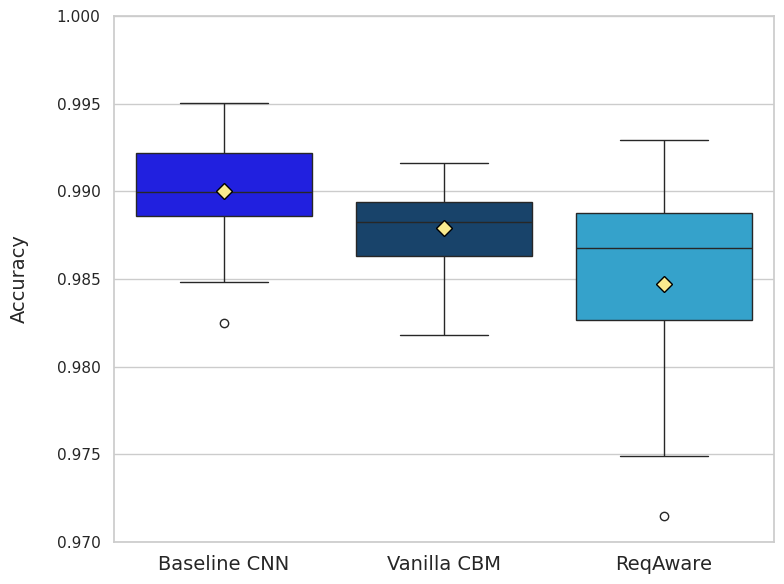

Box plot saved as 'f1_score_box_plot.png'.


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt


# Set a clean, academic style
sns.set_theme(style="whitegrid")

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Generate the box plot
sns.boxplot(
    x='model_type',        # The categorical variable (Model Types)
    y='accuracy',          # The metric you want to plot
    data=labels_df,
    ax=ax,
    palette=['#0200ff', '#0b4477', '#1cade4'], # Professional color scheme
    showmeans=True, # 1. Instructs seaborn to plot the mean
    meanline=False, # 2. Plots the mean as a marker (point), not a line
    meanprops={
        "marker": "D", # Use a Diamond marker
        "markerfacecolor": '#f9ea8e', # Fill the marker with red
        "markeredgecolor": "black", # Give the marker a black border
        "markersize": "8" # Adjust the size of the marker
    }
)

# Add titles and labels
# ax.set_title('Distribution of Accuracy on Label Prediction\n', fontsize=16)
ax.set_xlabel('', fontsize=14)
ax.set_ylabel('Accuracy\n', fontsize=14)

# Ensure the y-axis range is appropriate for performance metrics (0 to 1)
ax.set_ylim(0.97, 1)

# Add tick marks and labels for clarity
ax.tick_params(axis='x', which='major', labelsize=14)

# Optional: Add swarm plot or strip plot on top to show individual data points
# sns.stripplot(
#     x='model_type',
#     y='macro_f1',
#     data=labels_df,
#     color='black',
#     size=5,
#     jitter=True, # Add a small amount of random displacement to prevent overlap
#     alpha=0.6,
#     ax=ax
# )

# Save the figure with high resolution for publication
plt.tight_layout() # Adjusts plot to prevent labels from being cut off
plt.savefig(rq1_results_path / 'RQ1_accuracy_box_plot.png', dpi=300)
# plt.close() # Close the plot to free up memory

plt.show()
print("Box plot saved as 'f1_score_box_plot.png'.")

# Macro F1 of Concept predictions

In [17]:
fuzzy_concepts_df = fuzzy_concepts.filter(["macro_accuracy", "macro_f1"]).assign(model_type = 'ReqAware').reset_index()
baseline_concepts_df = baseline_concepts.filter(["macro_accuracy", "macro_f1"]).assign(model_type = 'Vanilla CBM').reset_index()

concepts_df = pd.concat([baseline_labels_df, fuzzy_labels_df])
concepts_df.columns = ["seed", "accuracy", "macro_f1", "model_type"]
concepts_df

concepts_df['model_type'] = pd.Categorical(
    concepts_df['model_type'], 
    categories=['Vanilla CBM', 'ReqAware'], 
    ordered=True
)

In [18]:
concepts_df.filter(['macro_f1', 'model_type']).groupby('model_type').agg([np.mean, np.median, np.std])

/tmp/ipykernel_63081/1417992198.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  concepts_df.filter(['macro_f1', 'model_type']).groupby('model_type').agg([np.mean, np.median, np.std])
/tmp/ipykernel_63081/1417992198.py:1: FutureWarning: The provided callable <function mean at 0x7fc224350ea0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  concepts_df.filter(['macro_f1', 'model_type']).groupby('model_type').agg([np.mean, np.median, np.std])
/tmp/ipykernel_63081/1417992198.py:1: FutureWarning: The provided callable <function median at 0x7fc2240867a0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep

macro_f1                    
                 mean    median       std
model_type                               
Vanilla CBM  0.981837  0.982562  0.005172
ReqAware     0.972648  0.979908  0.016046

/tmp/ipykernel_63081/1330611880.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


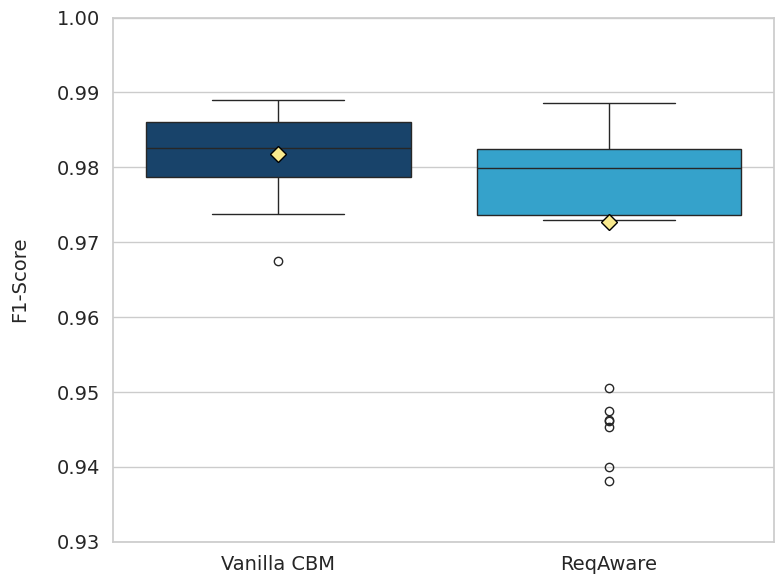

Box plot saved as 'RQ1_concetps_f1_score_box_plot.png'.


In [19]:
import seaborn as sns
import matplotlib.pyplot as plt


# Set a clean, academic style
sns.set_theme(style="whitegrid")

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Generate the box plot
sns.boxplot(
    x='model_type',        # The categorical variable (Model Types)
    y='macro_f1',          # The metric you want to plot
    data=concepts_df,
    ax=ax,
    palette=['#0b4477', '#1cade4'], # Professional color scheme
    showmeans=True, # 1. Instructs seaborn to plot the mean
    meanline=False, # 2. Plots the mean as a marker (point), not a line
    meanprops={
        "marker": "D", # Use a Diamond marker
        "markerfacecolor": '#f9ea8e', # Fill the marker with red
        "markeredgecolor": "black", # Give the marker a black border
        "markersize": "8" # Adjust the size of the marker
    }
)

# Add titles and labels
# ax.set_title('Distribution of F1-Scores by Model Type', fontsize=16)
ax.set_xlabel('', fontsize=14)
ax.set_ylabel('F1-Score\n', fontsize=14)

# Ensure the y-axis range is appropriate for performance metrics (0 to 1)
ax.set_ylim(0.93, 1)

# Add tick marks and labels for clarity
ax.tick_params(axis='both', which='major', labelsize=14)

# Optional: Add swarm plot or strip plot on top to show individual data points
# sns.stripplot(
#     x='model_type',
#     y='macro_f1',
#     data=labels_df,
#     color='black',
#     size=5,
#     jitter=True, # Add a small amount of random displacement to prevent overlap
#     alpha=0.6,
#     ax=ax
# )

# Save the figure with high resolution for publication
plt.tight_layout() # Adjusts plot to prevent labels from being cut off
plt.savefig(rq1_results_path / 'RQ1_concetps_f1_score_box_plot.png', dpi=300)
# plt.close() # Close the plot to free up memory

plt.show()
print("Box plot saved as 'RQ1_concetps_f1_score_box_plot.png'.")

# Finding the best models

In [127]:
fuzzy_concepts.sort_values(by='macro_accuracy', ascending=False).filter(['seed','macro_accuracy']).head(5)

,seed,macro_accuracy
26,s269,0.991291
25,s712,0.988599
7,s469,0.987173
29,s110,0.986857
14,s41,0.986698


In [ ]:
fuzzy_labels.sort_values(by='macro_accuracy', ascending=False).filter(['seed','macro_accuracy']).head(5)

,seed,macro_accuracy
26,s269,0.992953
25,s712,0.990261
14,s41,0.989786
22,s714,0.989311
15,s940,0.989153


In [126]:
baseline_concepts.sort_values(by='macro_accuracy', ascending=False).filter(['seed','macro_accuracy']).head(5)

,seed,macro_accuracy
4,s687,0.989628
18,s907,0.989074
6,s852,0.988994
2,s469,0.988915
20,s41,0.988044


In [128]:
baseline_labels.sort_values(by='macro_accuracy', ascending=False).filter(['seed','macro_accuracy']).head(5)

,seed,macro_accuracy
4,s687,0.991607
18,s907,0.991607
2,s469,0.991449
20,s41,0.991211
6,s852,0.990499
